# Debugging Pytorch Models

In [1]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_scalar("example", 3)


In [3]:
import random 
value = 10
writer.add_scalar("test_loop", value, 0)
for i in range(1,10000):
    value += random.random() - 0.5
    writer.add_scalar("test_loop", value, i)

## Visualizing Pytorch model

In [5]:
import torch
import torchvision 
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models 

writer = SummaryWriter()
model = models.resnet18(False)
writer.add_graph(model, torch.rand([1,3,224,224]))

C:\Users\PHM16\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\PHM16\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Pytorch hooks

In [11]:
def print_hook(module, input, output):
    print(f"Shape of input is {input[0].shape}")
model = models.resnet18()
# to know which module inside <model>, in this case we will see <fc>
for name, module in model.named_modules():
    print(name, ": ", type(module).__name__)

hook_ref = model.fc.register_forward_hook(print_hook)
model(torch.rand([1,3,224,224]))
hook_ref.remove()
model(torch.rand([1,3,224,224]))

 :  ResNet
conv1 :  Conv2d
bn1 :  BatchNorm2d
relu :  ReLU
maxpool :  MaxPool2d
layer1 :  Sequential
layer1.0 :  BasicBlock
layer1.0.conv1 :  Conv2d
layer1.0.bn1 :  BatchNorm2d
layer1.0.relu :  ReLU
layer1.0.conv2 :  Conv2d
layer1.0.bn2 :  BatchNorm2d
layer1.1 :  BasicBlock
layer1.1.conv1 :  Conv2d
layer1.1.bn1 :  BatchNorm2d
layer1.1.relu :  ReLU
layer1.1.conv2 :  Conv2d
layer1.1.bn2 :  BatchNorm2d
layer2 :  Sequential
layer2.0 :  BasicBlock
layer2.0.conv1 :  Conv2d
layer2.0.bn1 :  BatchNorm2d
layer2.0.relu :  ReLU
layer2.0.conv2 :  Conv2d
layer2.0.bn2 :  BatchNorm2d
layer2.0.downsample :  Sequential
layer2.0.downsample.0 :  Conv2d
layer2.0.downsample.1 :  BatchNorm2d
layer2.1 :  BasicBlock
layer2.1.conv1 :  Conv2d
layer2.1.bn1 :  BatchNorm2d
layer2.1.relu :  ReLU
layer2.1.conv2 :  Conv2d
layer2.1.bn2 :  BatchNorm2d
layer3 :  Sequential
layer3.0 :  BasicBlock
layer3.0.conv1 :  Conv2d
layer3.0.bn1 :  BatchNorm2d
layer3.0.relu :  ReLU
layer3.0.conv2 :  Conv2d
layer3.0.bn2 :  BatchNorm2d

tensor([[ 1.1201e-01, -3.3220e-01, -4.3342e-01,  1.6710e-01,  1.8900e-01,
         -2.6166e-01,  7.7308e-02, -7.7550e-02, -3.9189e-01, -6.6190e-01,
         -3.1226e-01, -1.0462e-01,  7.6775e-01, -3.5520e-01, -8.7061e-01,
         -8.5244e-01, -3.3240e-02, -4.5212e-01,  6.1402e-01,  2.8499e-01,
         -3.8119e-02,  2.1955e-01,  1.1794e-01, -4.9315e-01,  4.5624e-01,
          2.7205e-02, -1.5360e-01,  2.0879e-01, -8.6651e-01,  9.2366e-02,
          2.6604e-01,  7.7118e-01, -6.6005e-01,  1.6184e-01,  2.2298e-01,
         -7.1495e-01,  1.3548e-01,  2.3535e-02, -7.9252e-01,  1.9291e-01,
          2.6193e-02,  1.2149e+00,  8.8927e-02, -2.6923e-01, -1.5191e-01,
          5.1223e-01,  1.3379e-01,  2.8660e-01, -4.8421e-01,  6.4196e-01,
          3.7064e-02, -4.2430e-01,  9.0923e-01, -3.4581e-02, -4.8811e-01,
         -5.2825e-01,  2.9669e-02, -4.0871e-01, -3.9158e-01,  3.5068e-01,
         -4.5269e-01,  1.7131e-01, -2.6052e-01,  1.7699e+00, -2.6055e-01,
          5.1670e-01,  6.6476e-01,  1.

### Plotting mean and std

In [1]:
import torch 
import torch.nn as nn 
from torchvision import models
from torch.utils.tensorboard import SummaryWriter 
from torch.utils.data import DataLoader, TensorDataset
from functools import partial

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running with device ", device)
writer = SummaryWriter(log_dir="runs/act_stream")
model = models.resnet18(pretrained=False).to(device)

# record step during TRAINING only
train_step = {"value": 0}

# Every time a model is run, send e.g. conv2d/mean; conv2d/std; fc/mean; fc/std... info to Tensorboard
def send_stats(name, get_step, module, inp, out):
    # log only during training passes
    if not module.training:
        return
    if isinstance(out, (tuple, list)):
        out = out[0]
    if not torch.is_tensor(out):
        return
    out = out.detach() 
    step = get_step()
    writer.add_scalar(f"activations/train/{name}-mean", out.mean().item(), step)
    writer.add_scalar(f"activations/train/{name}-std", out.std().item(), step)
# use <partial> to pass function with arguments
hooks = []
for name, m in model.named_modules():
    hooks.append(m.register_forward_hook(partial(send_stats, name, lambda: train_step["value"])))

def train(model, optimizer, loss_fn, train_loader, test_loader, epochs=2):
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            # advance step once per batch
            train_step["value"] += 1
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) # hooks fire here (training=True)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            writer.add_scalar("train/loss", loss.item(), train_step["value"])
            
        model.eval()
        num_correct = 0
        num_examples = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                
                num_correct += (preds==targets).sum().item()
                num_examples += targets.size(0)
        acc = num_correct/num_examples if num_examples else 0.0
        print(f"Epoch {epoch+1}, accuracy={acc:.3f}")
        writer.add_scalar("val/accuracy", acc, train_step["value"])


Running with device  cuda


C:\Users\PHM16\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PHM16\anaconda3\envs\python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
# Dummy training data
Xtr = torch.randn(64,3,224,224); ytr = torch.randint(0,100,(64,))
Xva = torch.randn(16,3,224,224); yva = torch.randint(0,100,(16,))
train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(Xva, yva), batch_size=8)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2)

Epoch 1, accuracy=0.000
Epoch 2, accuracy=0.000


In [3]:
for h in hooks:
    h.remove()
writer.close()

## Class activation mapping

In [7]:
import torch
from torchvision import models, transforms 
from torch.nn import functional as F 
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = "casper.jpeg"
ALPHA = 0.45
device = "cuda" if torch.cuda.is_available() else "cpu"

class SaveActivations():
    def __init__(self, m):
        self.features = None
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.detach()
    def remove(self):
        self.hook.remove()
        

In [12]:
model = models.resnet18(pretrained=True).to(device).eval()
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485,0.456,0.406],
        std = [0.229, 0.224, 0.225]
    )
])
img_pil = Image.open(IMG_PATH).convert("RGB")
img_t = preprocess(img_pil).unsqueeze(0).to(device) # (1,3,224,224)
# here we hook to <model> already
act = SaveActivations(model.layer4) 
with torch.no_grad():
    logits = model(img_t) # output: (1,out_dim=1000)
    print(logits.shape)
    probs = F.softmax(logits,dim=1) # (1,1000)
    pred_idx = int(probs.argmax(dim=1).item())
    pred_prob = float(probs[0,pred_idx].item())
    

torch.Size([1, 1000])


In [13]:
act.features.shape

torch.Size([1, 512, 7, 7])

In [31]:
# fmap: last conv feature map; (512,7,7)
fmap = act.features[0] 
# weights: weights responsible for predicting that class
# model.fc.weight:(1000,512) => weights:(512,)
weights = model.fc.weight[pred_idx] 
print(fmap.shape)
print(weights.shape)

torch.Size([512, 7, 7])
torch.Size([512])


In [37]:
# CAM = channel-wise weighted sum
C,H,W = fmap.shape # C=512, H=7, W=7
cam = weights @ fmap.view(C,H*W) # (512,) @ (512,H*W) => (H*W,) (sum of channel-weights per location for predicted class)
cam = cam.view(H,W) # (7,7)


In [38]:
C,H,W
cam.shape

torch.Size([7, 7])

In [39]:
# normalize to [0,1]
cam -= cam.min()
cam /= (cam.max() + 1e-8)

In [40]:
newW, newH = img_pil.size (224,224)
cam_up = F.interpolate(
    cam.unsqueeze(0).unsqueeze(0), # (1,1,7,7)
    size=(newH,newW),
    mode = "bilinear",
    align_corners=False    
).squeeze().detach().cpu().numpy()


In [42]:
cam_up.shape

(224, 224)

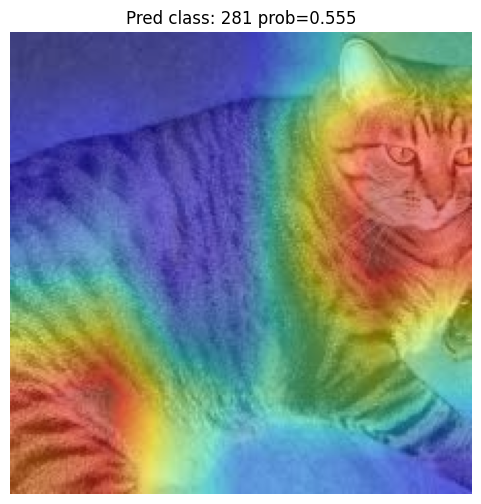

In [44]:
plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.imshow(cam_up, alpha=ALPHA, cmap="jet")
plt.title(f"Pred class: {pred_idx} prob={pred_prob:.3f}")
plt.axis("off")
plt.show()

In [45]:
# Clean hook
act.remove()

## Flame Graphs